In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import RobustScaler
from datetime import datetime

#Ruta al directorio base y del archivo Silver
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname('__file__'), "..", ".."))
SILVER_DIR = os.path.join(BASE_DIR, "data", "silver")
SILVER_FILE_PATH = os.path.join(SILVER_DIR, "silver_data.parquet")

# Cargar el dataset Silver
try:
    df_gold = pd.read_parquet(SILVER_FILE_PATH)
    print(f"Dimensiones del DataFrame: {df_gold.shape}")
    print(display(df_gold.head()))
    print("\nInformación del DataFrame:")
    df_gold.info()
except Exception as e:
    print(f"Ocurrio un error al cargar los datos Silver: {e}")


Dimensiones del DataFrame: (28128, 8)


,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position
timestamp,,,,,,,,
2024-09-10 04:00:00,131.041825,739.327177,50.900000,26.500000,54.653733,178.928398,30.745757,10
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11


None

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28128 entries, 2024-09-10 04:00:00 to 2025-06-30 03:45:00
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   voltaje                     28128 non-null  float64
 1   corriente_carga             28128 non-null  float64
 2   temperatura_aceite          28128 non-null  float64
 3   temperatura_ambiente        28128 non-null  float64
 4   temperatura_punto_caliente  28128 non-null  float64
 5   temperatura_burbujeo        28128 non-null  float64
 6   potencia_aparente           28128 non-null  float64
 7   tap_position                28128 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1.9 MB


# Ingeniera de Caracteristicas


In [3]:
df_gold['hour_of_day'] = df_gold.index.hour
df_gold['day_of_week'] = df_gold.index.dayofweek # Lunes=0, Domingo=6
df_gold['month_of_year'] = df_gold.index.month
df_gold['day_of_year'] = df_gold.index.dayofyear
df_gold['week_of_year'] = df_gold.index.isocalendar().week.astype(int) # Necesita ser int para algunos modelos
df_gold['is_weekend'] = (df_gold.index.dayofweek >= 5).astype(int) # 1 si es fin de semana, 0 si no
df_gold['quarter_of_year'] = df_gold.index.quarter # Trimestre del año
print("\n DataFrame Gold con características temporales:")
print(display(df_gold.head()))



 DataFrame Gold con características temporales:


,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position,hour_of_day,day_of_week,month_of_year,day_of_year,week_of_year,is_weekend,quarter_of_year
timestamp,,,,,,,,,,,,,,,
2024-09-10 04:00:00,131.041825,739.327177,50.900000,26.500000,54.653733,178.928398,30.745757,10,4,1,9,254,37,0,3
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11,4,1,9,254,37,0,3
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11,4,1,9,254,37,0,3
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11,4,1,9,254,37,0,3
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11,5,1,9,254,37,0,3


None


2.2 Características Diferenciales y de Relación

In [4]:
# Diferencial Temperatura Aceite-Ambiente
df_gold['temp_aceite_diff_ambiente'] = df_gold['temperatura_aceite'] - df_gold['temperatura_ambiente']
# Diferencial Punto Caliente-Aceite
df_gold['punto_caliente_diff_aceite'] = df_gold['temperatura_punto_caliente'] - df_gold['temperatura_aceite']

df_gold.head()

,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position,hour_of_day,day_of_week,month_of_year,day_of_year,week_of_year,is_weekend,quarter_of_year,temp_aceite_diff_ambiente,punto_caliente_diff_aceite
timestamp,,,,,,,,,,,,,,,,,
2024-09-10 04:00:00,131.041825,739.327177,50.900000,26.500000,54.653733,178.928398,30.745757,10,4,1,9,254,37,0,3,24.400000,3.753733
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11,4,1,9,254,37,0,3,26.850000,5.142727
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11,4,1,9,254,37,0,3,26.542857,4.965217
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11,4,1,9,254,37,0,3,26.585714,4.787707
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11,5,1,9,254,37,0,3,26.795238,4.610197


Tasa de cambio (Ej: promedio de la última hora para temperaturas)
Se usa .diff() para la diferencia y luego .rolling().mean() para suavizar el ruido en la tasa de cambio
Puedes ajustar la ventana de '1H' (1 hora) según lo que consideres relevante

In [5]:

print("Calculando tasas de cambio...")
df_gold['delta_temp_aceite_1h'] = df_gold['temperatura_aceite'].diff().rolling(window='1h').mean()
df_gold['delta_potencia_aparente_1h'] = df_gold['potencia_aparente'].diff().rolling(window='1h').mean()
df_gold['delta_voltaje_1h'] = df_gold['voltaje'].diff().rolling(window='1h').mean()
df_gold.head(10)


Calculando tasas de cambio...


,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position,hour_of_day,day_of_week,month_of_year,day_of_year,week_of_year,is_weekend,quarter_of_year,temp_aceite_diff_ambiente,punto_caliente_diff_aceite,delta_temp_aceite_1h,delta_potencia_aparente_1h,delta_voltaje_1h
timestamp,,,,,,,,,,,,,,,,,,,,
2024-09-10 04:00:00,131.041825,739.327177,50.900000,26.500000,54.653733,178.928398,30.745757,10,4,1,9,254,37,0,3,24.400000,3.753733,NaN,NaN,NaN
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11,4,1,9,254,37,0,3,26.850000,5.142727,2.600000,-0.513023,-0.348752
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11,4,1,9,254,37,0,3,26.542857,4.965217,1.221428,-0.510039,-0.114684
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11,4,1,9,254,37,0,3,26.585714,4.787707,0.761905,-0.527025,-0.038990
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11,5,1,9,254,37,0,3,26.795238,4.610197,0.532143,-0.533776,-0.119352
2024-09-10 05:15:00,130.947408,679.651644,52.871428,25.866667,57.304115,176.126086,28.242603,11,5,1,9,254,37,0,3,27.004762,4.432687,-0.157143,-0.497533,0.063584
2024-09-10 05:30:00,131.011387,671.082906,52.714285,25.500000,57.232162,176.001775,27.921659,10,5,1,9,254,37,0,3,27.214285,4.517877,-0.157143,-0.451005,0.049733
2024-09-10 05:45:00,131.140706,663.630621,52.557143,26.299999,56.913330,175.877464,27.625818,11,5,1,9,254,37,0,3,26.257143,4.356188,-0.157143,-0.384716,0.053963
2024-09-10 06:00:00,131.046645,656.529251,52.400000,26.500000,56.749290,175.753153,27.324530,11,6,1,9,254,37,0,3,25.900000,4.349291,-0.157143,-0.321531,0.120557


In [6]:
for col in df_gold.columns:
    print(f"Procesando columna: {df_gold[col].isnull().sum()} valores nulos")

Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 1 valores nulos
Procesando columna: 1 valores nulos
Procesando columna: 1 valores nulos


 Algunas de estas nuevas columnas tendrán NaNs al principio debido a .diff() y .rolling(). de las caracteristicas creadas

In [7]:

df_gold.dropna(inplace=True) # Eliminar filas con NaNs
print("\nDataFrame Gold después de eliminar filas con NaNs:")
print(display(df_gold.head()))


DataFrame Gold después de eliminar filas con NaNs:


,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position,hour_of_day,day_of_week,month_of_year,day_of_year,week_of_year,is_weekend,quarter_of_year,temp_aceite_diff_ambiente,punto_caliente_diff_aceite,delta_temp_aceite_1h,delta_potencia_aparente_1h,delta_voltaje_1h
timestamp,,,,,,,,,,,,,,,,,,,,
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11,4,1,9,254,37,0,3,26.850000,5.142727,2.600000,-0.513023,-0.348752
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11,4,1,9,254,37,0,3,26.542857,4.965217,1.221428,-0.510039,-0.114684
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11,4,1,9,254,37,0,3,26.585714,4.787707,0.761905,-0.527025,-0.038990
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11,5,1,9,254,37,0,3,26.795238,4.610197,0.532143,-0.533776,-0.119352
2024-09-10 05:15:00,130.947408,679.651644,52.871428,25.866667,57.304115,176.126086,28.242603,11,5,1,9,254,37,0,3,27.004762,4.432687,-0.157143,-0.497533,0.063584


None


2.3 Manejo de Multicolinealidad (Selección de Características)
Según el heatmap:
- 'corriente_carga' y 'potencia_aparente' (0.99): Se escogera potencia aparente debido a que esta abarca tambien la corriente en su formula
- 'temperatura_aceite', 'temperatura_punto_caliente', 'temperatura_burbujeo' (todas >0.98): Se elige 'temperatura_punto_caliente' como la más crítica y, opcionalmente, una más si es muy relevante.

In [8]:
df_copy= df_gold.copy()  # Copia del DataFrame original para evitar problemas de referencia
# Lista de columnas a eliminar debido a alta multicolinealidad o redundancia en los datos
cols_to_drop_for_multicollinearity = [
    'corriente_carga',  # Alta correlación con corriente_carga
    'temperatura_aceite',
    'temperatura_burbujeo'
]

# Asegurarse de que las columnas existan antes de intentar eliminarlas
existing_cols_to_drop = [col for col in cols_to_drop_for_multicollinearity if col in df_copy.columns]

if existing_cols_to_drop:
    df_copy = df_copy.drop(columns=existing_cols_to_drop)
    print(f"Columnas eliminadas por multicolinealidad: {existing_cols_to_drop}")
else:
    print("No se encontraron columnas para eliminar por multicolinealidad o ya fueron eliminadas.")

print(f"Dimensiones del DataFrame después de Feature Engineering: {df_copy.shape}")
print(df_copy.head())

Columnas eliminadas por multicolinealidad: ['corriente_carga', 'temperatura_aceite', 'temperatura_burbujeo']
Dimensiones del DataFrame después de Feature Engineering: (28127, 17)
                        voltaje  temperatura_ambiente  \
timestamp                                               
2024-09-10 04:15:00  130.693073             26.650000   
2024-09-10 04:30:00  130.812457             26.800000   
2024-09-10 04:45:00  130.924854             26.600000   
2024-09-10 05:00:00  130.564417             26.233334   
2024-09-10 05:15:00  130.947408             25.866667   

                     temperatura_punto_caliente  potencia_aparente  \
timestamp                                                            
2024-09-10 04:15:00                   58.642727          30.232734   
2024-09-10 04:30:00                   58.308074          29.725678   
2024-09-10 04:45:00                   57.973421          29.164683   
2024-09-10 05:00:00                   57.638768          28.610652   
2

Escalado de caracteristicas
Se define las columnas que no se van a escalar, tap position y las variables de tiempo

In [9]:
# Definir las columnas que no se van a escalar
# Estas son las columnas de tiempo y 'tap_position' que no deben ser escaladas
excluded_cols_from_scaling = [
    'tap_position','hour_of_day', 'day_of_week', 'month_of_year', 'day_of_year',
    'week_of_year', 'is_weekend', 'quarter_of_year', 
]

# Columnas a escalar: todas las numéricas que no estén en la lista de exclusión
# y que no sean el índice
cols_to_scale = [col for col in df_copy.select_dtypes(include=np.number).columns if col not in excluded_cols_from_scaling]
print(f"Columnas a escalar: {cols_to_scale}")

if not cols_to_scale:
    print("No se encontraron columnas numéricas para escalar. Revisa la lista de exclusión o tipos de datos.")
else:
    scaler = RobustScaler()
    print(f"Escalando las siguientes columnas con RobustScaler: {cols_to_scale}")
    df_copy[cols_to_scale] = scaler.fit_transform(df_copy[cols_to_scale])
    print("Características escaladas con RobustScaler.")

print("\nPrimeras 5 filas del DataFrame_copy después de escalado:")
print(display(df_copy.head()))
print(f"Dimensiones finales del DataFrame_copy: {df_copy.shape}")

Columnas a escalar: ['voltaje', 'temperatura_ambiente', 'temperatura_punto_caliente', 'potencia_aparente', 'temp_aceite_diff_ambiente', 'punto_caliente_diff_aceite', 'delta_temp_aceite_1h', 'delta_potencia_aparente_1h', 'delta_voltaje_1h']
Escalando las siguientes columnas con RobustScaler: ['voltaje', 'temperatura_ambiente', 'temperatura_punto_caliente', 'potencia_aparente', 'temp_aceite_diff_ambiente', 'punto_caliente_diff_aceite', 'delta_temp_aceite_1h', 'delta_potencia_aparente_1h', 'delta_voltaje_1h']
Características escaladas con RobustScaler.

Primeras 5 filas del DataFrame_copy después de escalado:


,voltaje,temperatura_ambiente,temperatura_punto_caliente,potencia_aparente,tap_position,hour_of_day,day_of_week,month_of_year,day_of_year,week_of_year,is_weekend,quarter_of_year,temp_aceite_diff_ambiente,punto_caliente_diff_aceite,delta_temp_aceite_1h,delta_potencia_aparente_1h,delta_voltaje_1h
timestamp,,,,,,,,,,,,,,,,,
2024-09-10 04:15:00,0.117880,0.145068,0.496258,0.158097,11,4,1,9,254,37,0,3,0.970291,0.169042,9.905655,-0.919998,-1.013722
2024-09-10 04:30:00,0.155470,0.162476,0.470274,0.105875,11,4,1,9,254,37,0,3,0.902339,0.103118,4.703502,-0.914524,-0.353677
2024-09-10 04:45:00,0.190859,0.139265,0.444289,0.048098,11,4,1,9,254,37,0,3,0.911820,0.037194,2.969451,-0.945687,-0.140230
2024-09-10 05:00:00,0.077372,0.096712,0.418305,-0.008962,11,5,1,9,254,37,0,3,0.958175,-0.028729,2.102425,-0.958074,-0.366840
2024-09-10 05:15:00,0.197960,0.054159,0.392320,-0.046868,11,5,1,9,254,37,0,3,1.004530,-0.094653,-0.498651,-0.891579,0.149017


None
Dimensiones finales del DataFrame_copy: (28127, 17)


Division de datos (Entrenamiento, Validacion y Prueba)

In [10]:
# Definir los porcentajes (puedes ajustarlos)
train_ratio = 0.8
val_ratio = 0.10 # Validación
test_ratio = 0.10 # Prueba  

# Asegurarse de que los ratios sumen 1 o menos
if (train_ratio + val_ratio + test_ratio) > 1.0:
    print("Advertencia: La suma de los ratios es mayor a 1. Ajustando test_ratio.")
    test_ratio = 1.0 - train_ratio - val_ratio
    if test_ratio < 0: test_ratio = 0 # Asegurarse que no sea negativo

total_rows = df_copy.shape[0]
train_split = int(total_rows * train_ratio)
val_split = int(total_rows * (train_ratio + val_ratio))

# Dividir el DataFrame
df_train = df_copy.iloc[:train_split]
df_val = df_copy.iloc[train_split:val_split]
df_test = df_copy.iloc[val_split:]

print(f"Total de registros: {total_rows}")
print(f"Conjunto de Entrenamiento: {len(df_train)} registros ({(len(df_train)/total_rows)*100:.2f}%)")
print(f"Conjunto de Validación: {len(df_val)} registros ({(len(df_val)/total_rows)*100:.2f}%)")
print(f"Conjunto de Prueba: {len(df_test)} registros ({(len(df_test)/total_rows)*100:.2f}%)")

print("\nFechas de los conjuntos:")
print(f"  Entrenamiento: {df_train.index.min()} a {df_train.index.max()}")
print(f"  Validación:    {df_val.index.min()} a {df_val.index.max()}")
print(f"  Prueba:        {df_test.index.min()} a {df_test.index.max()}")

# Opcional: Guardar los datasets resultantes
# Asegúrate de crear una carpeta para los datos Gold si aún no existe
GOLD_DIR = os.path.join(BASE_DIR, "data", "gold")
os.makedirs(GOLD_DIR, exist_ok=True)

df_train.to_parquet(os.path.join(GOLD_DIR, "train_data.parquet"), index=True)
df_val.to_parquet(os.path.join(GOLD_DIR, "val_data.parquet"), index=True)
df_test.to_parquet(os.path.join(GOLD_DIR, "test_data.parquet"), index=True)

print(f"\nDatasets Gold guardados en: {GOLD_DIR}")

Total de registros: 28127
Conjunto de Entrenamiento: 22501 registros (80.00%)
Conjunto de Validación: 2813 registros (10.00%)
Conjunto de Prueba: 2813 registros (10.00%)

Fechas de los conjuntos:
  Entrenamiento: 2024-09-10 04:15:00 a 2025-05-02 13:15:00
  Validación:    2025-05-02 13:30:00 a 2025-05-31 20:30:00
  Prueba:        2025-05-31 20:45:00 a 2025-06-30 03:45:00

Datasets Gold guardados en: c:\Users\Asus TUF\Desktop\proy_ml\data\gold


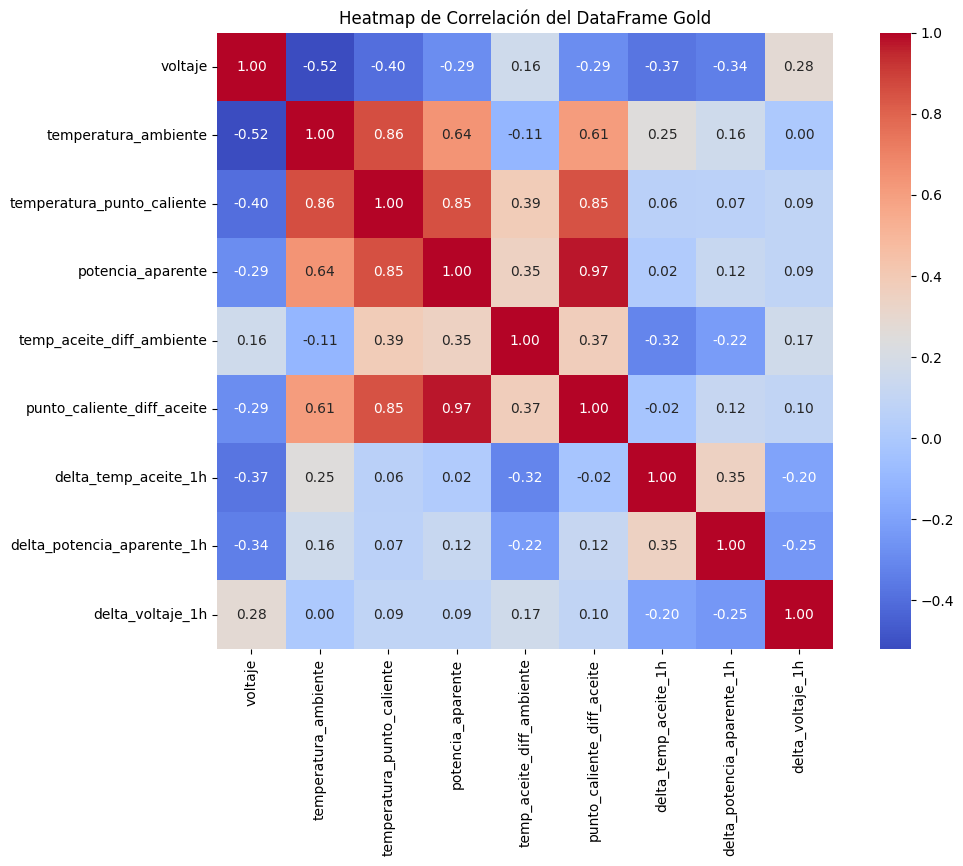

In [11]:
#funcion para graficar el heatmap de correlación
def plot_correlation_heatmap(df, title="Heatmap de Correlación"):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title(title)
    plt.show()
plot_correlation_heatmap(df_copy[cols_to_scale], title="Heatmap de Correlación del DataFrame Gold")


In [12]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Recargar los datos Gold (si no continuas del notebook anterior) ---
# Si continuas del mismo notebook, puedes saltar esta parte
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname('__file__'), "..",".."))
GOLD_DIR = os.path.join(BASE_DIR, "data", "gold")

try:
    df_train = pd.read_parquet(os.path.join(GOLD_DIR, "train_data.parquet"))
    df_val = pd.read_parquet(os.path.join(GOLD_DIR, "val_data.parquet"))
    df_test = pd.read_parquet(os.path.join(GOLD_DIR, "test_data.parquet"))
    print("Datasets Gold (Train, Val, Test) cargados correctamente.")
except FileNotFoundError:
    print(f"Error: No se encontraron los archivos Parquet en {GOLD_DIR}")
    print("Asegúrate de haber guardado los datasets de la capa Gold en el paso anterior.")
    # Si no se encuentran, puedes salir o manejar el error.
    exit()

Datasets Gold (Train, Val, Test) cargados correctamente.


In [13]:
# Definir la variable objetivo
TARGET_VARIABLE = 'temperatura_punto_caliente'

# Lista de todas las columnas, excluimos las que serán target o causan data leakage.
features_to_exclude = [TARGET_VARIABLE]
features = [col for col in df_train.columns if col not in features_to_exclude]

# pero es bueno verificar que las columnas esperadas estén ahí.
missing_excluded_features = [f for f in features_to_exclude if f not in df_train.columns]
if missing_excluded_features:
    print(f"caracteristicas a excluir no se encontraron en el DataFrame: {missing_excluded_features}")

# Crear los conjuntos X e Y
X_train = df_train[features]
Y_train = df_train[TARGET_VARIABLE]

X_val = df_val[features]
Y_val = df_val[TARGET_VARIABLE]

X_test = df_test[features]

Y_test = df_test[TARGET_VARIABLE]

print(f"\nConjuntos X e Y creados para Entrenamiento, Validación y Prueba.")
print(f"Número de características (X): {len(features)}")
print(f"Ejemplo de características: {features[:5]}...") # Muestra las primeras 5 características
print(f"Variable Objetivo (Y): {TARGET_VARIABLE}")

print(f"\nDimensiones de los conjuntos:")
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_val:   {X_val.shape}, Y_val:   {Y_val.shape}")
print(f"X_test:  {X_test.shape}, Y_test:  {Y_test.shape}")


Conjuntos X e Y creados para Entrenamiento, Validación y Prueba.
Número de características (X): 16
Ejemplo de características: ['voltaje', 'temperatura_ambiente', 'potencia_aparente', 'tap_position', 'hour_of_day']...
Variable Objetivo (Y): temperatura_punto_caliente

Dimensiones de los conjuntos:
X_train: (22501, 16), Y_train: (22501,)
X_val:   (2813, 16), Y_val:   (2813,)
X_test:  (2813, 16), Y_test:  (2813,)


In [14]:
df_test

,voltaje,temperatura_ambiente,temperatura_punto_caliente,potencia_aparente,tap_position,hour_of_day,day_of_week,month_of_year,day_of_year,week_of_year,is_weekend,quarter_of_year,temp_aceite_diff_ambiente,punto_caliente_diff_aceite,delta_temp_aceite_1h,delta_potencia_aparente_1h,delta_voltaje_1h
timestamp,,,,,,,,,,,,,,,,,
2025-05-31 20:45:00,-0.303037,-0.967118,-0.658788,-0.139008,8,20,5,5,151,22,1,2,-0.011273,-0.148763,-0.037735,0.495838,-0.028065
2025-05-31 21:00:00,-0.230576,-0.998066,-0.642157,0.005939,8,21,5,5,151,22,1,2,0.034450,-0.046931,-0.084904,0.983660,0.191039
2025-05-31 21:15:00,-0.175077,-1.050290,-0.625525,0.060037,8,21,5,5,151,22,1,2,0.120733,0.054900,-0.132074,1.092845,0.127573
2025-05-31 21:30:00,-0.068147,-1.102514,-0.608893,0.140330,8,21,5,5,151,22,1,2,0.207016,0.156732,-0.132074,1.345657,0.216875
2025-05-31 21:45:00,-0.143675,-1.154739,-0.612154,0.199361,8,21,5,5,151,22,1,2,0.306574,0.141138,-0.075470,1.528196,0.326529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30 02:45:00,0.486209,-1.029400,-1.307084,-0.092144,8,2,0,6,181,27,0,2,-0.251370,-2.647205,6.375559,-0.863422,0.253679
2025-06-30 03:00:00,0.524679,-0.535524,-0.173967,-0.136190,8,3,0,6,181,27,0,2,0.575275,-0.195605,13.868013,-0.704949,0.401731
2025-06-30 03:15:00,0.576869,-0.734816,-0.171347,-0.180237,8,3,0,6,181,27,0,2,0.226264,1.040536,10.712574,-0.699209,0.449285


In [15]:
# ML imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
def train_and_evaluate_xgboost(model, X_train, y_train, X_test, y_test, max_estimators=200):
    """
    Entrena un modelo XGBoost variando el número de estimadores y guarda las métricas.

    Retorna:
    - train_losses: lista con las pérdidas de entrenamiento
    - test_losses: lista con las pérdidas de prueba
    - test_accuracies: lista con las precisiones de prueba (R² en regresión)
    """
    train_accuracies = []
    train_losses = []
    test_losses = []
    test_accuracies = []

    for n_estimators in range(1, max_estimators + 1):
        model.set_params(n_estimators=n_estimators)
        model.fit(X_train, y_train)


        # Predicciones
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calcular métricas
        train_accuracy = r2_score(y_train, y_train_pred)
        train_loss = mean_absolute_error(y_train, y_train_pred)
        test_loss = mean_absolute_error(y_test, y_test_pred)
        test_accuracy = r2_score(y_test, y_test_pred)

        # Guardar métricas
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Imprimir progreso
        print(f"Estimators: {n_estimators}/{max_estimators}.. Tr MAE: {train_loss:.3f}.. Test MAE: {test_loss:.3f}.. tr R²: {train_accuracy:.3f}.. Test R²: {test_accuracy:.3f}")

    return train_losses, test_losses, test_accuracies, train_accuracies

def plot_training_metrics(train_losses, test_losses, test_accuracies, train_accuracies, max_estimators=200):
    """
    Grafica las métricas de entrenamiento y prueba obtenidas.

    """

    plt.figure(figsize=(8, 3))

    # Gráfica de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_estimators + 1), train_losses, label='Training Loss')
    plt.plot(range(1, max_estimators + 1), test_losses, label='Test Loss')
    plt.xlabel("Estimators")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Test Loss")

    # Gráfica de precisión (R²)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, max_estimators + 1), test_accuracies, label='Test Accuracy (R²)', color='orange')
    plt.plot(range(1, max_estimators + 1), train_accuracies, label='Test Accuracy (R²)', color='blue')
    plt.xlabel("Estimators")
    plt.ylabel("Accuracy (R²)")
    plt.legend()
    plt.title("Test Accuracy (R²)")

    plt.tight_layout()
    plt.show()

def plot_test_predictions(y_test, y_test_pred):
    """
    Grafica las predicciones vs valores reales y los residuos en el conjunto de prueba.

    """

    # Gráfico de dispersión: Predicciones vs Valores Reales
    plt.figure(figsize=(8, 3))
    plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal (y = x)')
    plt.xlabel("Real Values")
    plt.ylabel("Predicted Values")
    plt.title("Predictions vs Real Values (Test Set)")
    plt.legend()
    plt.show()

    # Gráfico de residuos
    residuals = y_test - y_test_pred
    plt.figure(figsize=(8, 4))
    plt.scatter(y_test, residuals, color='green', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Real Values")
    plt.ylabel("Residuals (Error)")
    plt.title("Residuals vs Real Values (Test Set)")
    plt.show()

 Selección y Entrenamiento de Modelos

In [16]:
# 1. Modelo Random Forest Regressor
print("\nEntrenando Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 usa todos los núcleos
rf_model.fit(X_train, Y_train)
print("Random Forest Regressor entrenado.")

# 2. Modelo XGBoost Regressor
print("\nEntrenando XGBoost Regressor...")
# XGBoost es muy potente y rápido
estimators = 500  # Número de árboles en el modelo
params = { 
    "n_estimators":estimators,
    "learning_rate":0.1,# esto por defecto es 0.1, pero lo bajamos para mayor precisión
    "gamma": 3, # Regularización para evitar sobreajuste
    "max_depth": 3, # Profundidad máxima del árbol
    "min_child_weight": 9, # Peso mínimo de la hoja
    "subsample":0.5, # Submuestra de datos para cada árbol
    "colsample_bytree": 0.5, # Columna de muestra por árbol
    "objective":'reg:squarederror', # Objetivo de regresión cuadrática
    "random_state":42, # 
    "n_jobs":3, 
    "reg_lambda": 2
}
xgb_model = XGBRegressor(**params)
xgb_model.fit(X_train, Y_train)
print("XGBoost Regressor entrenado.")


Entrenando Random Forest Regressor...
Random Forest Regressor entrenado.

Entrenando XGBoost Regressor...
XGBoost Regressor entrenado.


Evaluación de Modelos

In [17]:

def evaluate_model(model, X, Y, name="Modelo"):
    """
    Evalúa el modelo y imprime métricas de regresión.
    """
    predictions = model.predict(X)

    mae = mean_absolute_error(Y, predictions)
    rmse = np.sqrt(mean_squared_error(Y, predictions))
    r2 = r2_score(Y, predictions)

    print(f"\nResultados de {name}:")
    print(f"  MAE (Mean Absolute Error): {mae:.3f}")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.3f}")
    print(f"  R2 (Coefficient of Determination): {r2:.3f}")
    return predictions

# --- Evaluación en el conjunto de VALIDACIÓN ---
print("\nEvaluando en el conjunto de VALIDACIÓN:")
rf_val_predictions = evaluate_model(rf_model, X_val, Y_val, "Random Forest (Validación)")
xgb_val_predictions = evaluate_model(xgb_model, X_val, Y_val, "XGBoost (Validación)")

# --- Opcional: Evaluación en el conjunto de ENTRENAMIENTO (para verificar overfitting) ---
# Esto es solo para diagnóstico. Si las métricas en entrenamiento son mucho mejores que en validación, hay overfitting.
print("\nEvaluando en el conjunto de ENTRENAMIENTO (solo para diagnóstico de overfitting):")
evaluate_model(rf_model, X_train, Y_train, "Random Forest (Entrenamiento)")
evaluate_model(xgb_model, X_train, Y_train, "XGBoost (Entrenamiento)")


Evaluando en el conjunto de VALIDACIÓN:

Resultados de Random Forest (Validación):
  MAE (Mean Absolute Error): 0.032
  RMSE (Root Mean Squared Error): 0.080
  R2 (Coefficient of Determination): 0.960

Resultados de XGBoost (Validación):
  MAE (Mean Absolute Error): 0.112
  RMSE (Root Mean Squared Error): 0.184
  R2 (Coefficient of Determination): 0.790

Evaluando en el conjunto de ENTRENAMIENTO (solo para diagnóstico de overfitting):

Resultados de Random Forest (Entrenamiento):
  MAE (Mean Absolute Error): 0.005
  RMSE (Root Mean Squared Error): 0.008
  R2 (Coefficient of Determination): 1.000

Resultados de XGBoost (Entrenamiento):
  MAE (Mean Absolute Error): 0.069
  RMSE (Root Mean Squared Error): 0.090
  R2 (Coefficient of Determination): 0.981


array([ 0.37441033,  0.33728606,  0.2881066 , ..., -0.39679486,
       -0.30121243, -0.28092614], shape=(22501,), dtype=float32)

1. Análisis de los Resultados de la Evaluación 📊
Mira las métricas que obtuviste en el paso anterior para Random Forest y XGBoost en el conjunto de VALIDACIÓN:

MAE (Mean Absolute Error): Este es el error promedio de tus predicciones en las unidades de tu variable objetivo (grados Celsius en este caso). Un MAE bajo es bueno. Por ejemplo, si el MAE es de 0.5, significa que, en promedio, tus predicciones se desvían 0.5°C de la temperatura real.
En promedio la prediccion se desvia en un 0.041 de la temperatura real 

RMSE (Root Mean Squared Error): Similar al MAE, pero penaliza más los errores grandes. Si el RMSE es mucho mayor que el MAE, significa que hay algunos errores grandes en tus predicciones. Un RMSE bajo es bueno. con los resultados obtenidos se tienen un 0.112

R² (Coefficient of Determination): Indica la proporción de la varianza en la variable objetivo que es predecible a partir de tus características. Un R² cercano a 1.0 es ideal, significando que el modelo explica una gran parte de la variabilidad de la temperatura del punto caliente.
en comparacion entre un random forest existe unos mejores resultados que xgboost

Pregúntate:

¿Qué modelo tuvo el mejor rendimiento en el conjunto de validación (menor MAE/RMSE y mayor R²)? Este será tu modelo base para la optimización.

¿Hay una diferencia significativa entre el rendimiento en el conjunto de entrenamiento y el de validación? Si el rendimiento en entrenamiento es mucho mejor, indica que tu modelo podría estar sobreajustado (overfitting). Esto significa que el modelo memorizó los datos de entrenamiento pero no generaliza bien a datos nuevos.


--- Visualización de Predicciones en el Conjunto de Validación ---


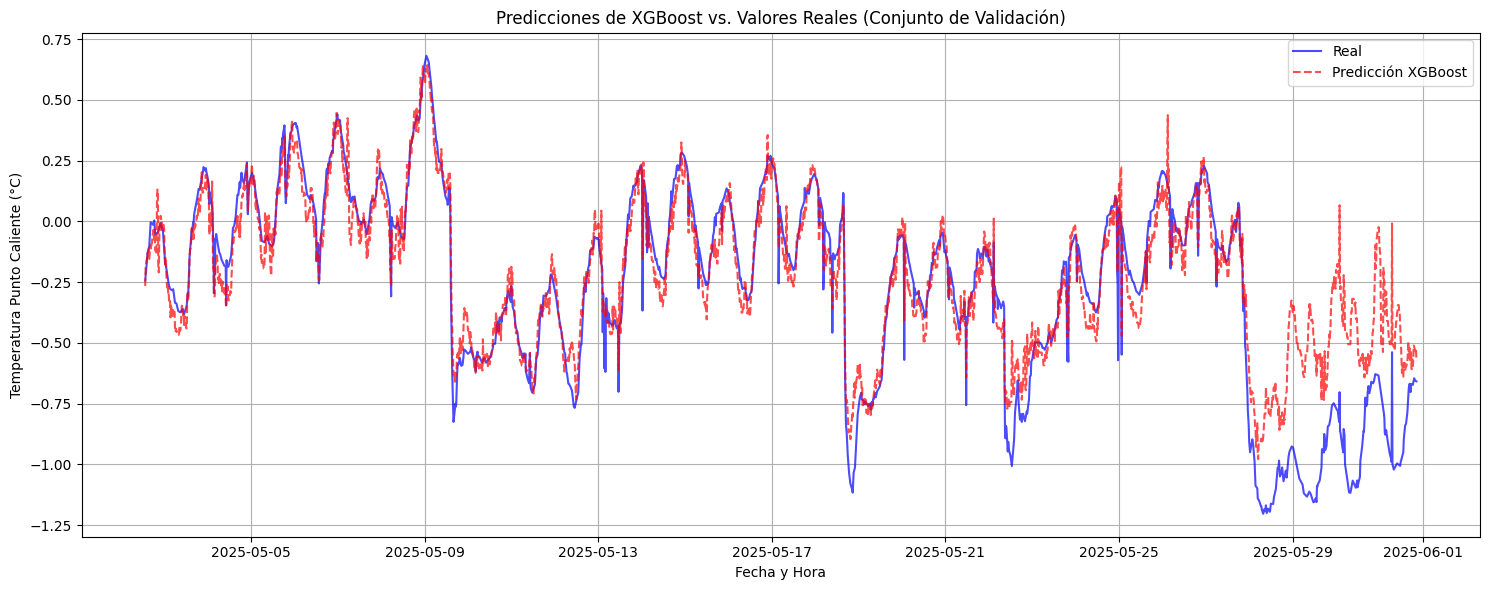

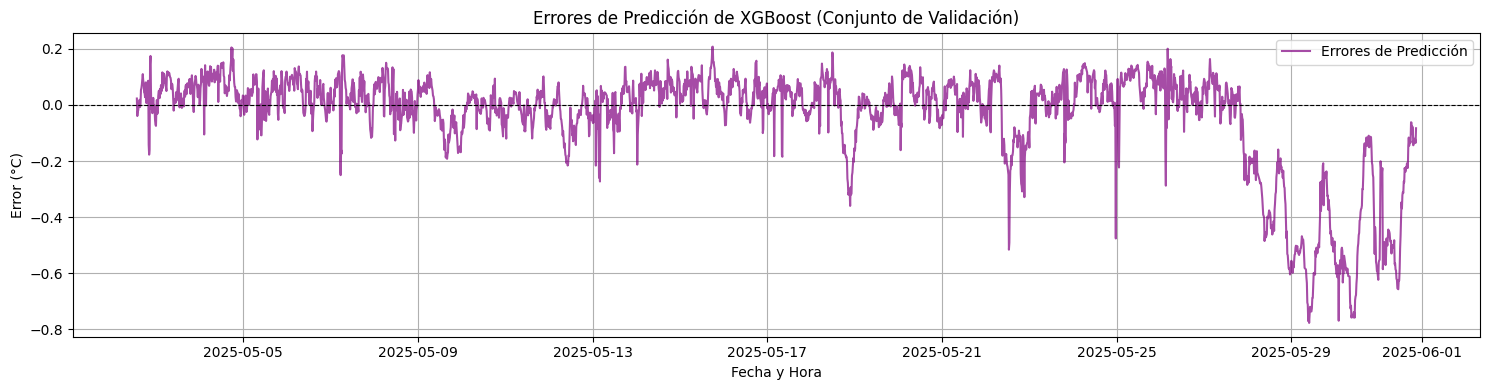

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Visualización de Predicciones en el Conjunto de Validación ---")

# Elegir el modelo con mejor rendimiento en validación para la visualización
# Por ejemplo, si XGBoost fue mejor, usaremos sus predicciones
# Asegúrate de que las predicciones ya se generaron en el paso anterior
# rf_val_predictions o xgb_val_predictions

# Si no tienes las predicciones guardadas, vuelve a generarlas:
rf_val_predictions = rf_model.predict(X_val)
xgb_val_predictions = xgb_model.predict(X_val)

# Elige el modelo a visualizar (ej. XGBoost si te dio mejores métricas)
model_to_visualize_predictions = xgb_val_predictions # Cambia a rf_val_predictions si Random Forest fue mejor
model_name = "XGBoost" # Cambia a "Random Forest" si Random Forest fue mejor

plt.figure(figsize=(15, 6))
plt.plot(Y_val.index, Y_val, label='Real', color='blue', alpha=0.7)
plt.plot(Y_val.index, model_to_visualize_predictions, label=f'Predicción {model_name}', color='red', linestyle='--', alpha=0.7)
plt.title(f'Predicciones de {model_name} vs. Valores Reales (Conjunto de Validación)')
plt.xlabel('Fecha y Hora')
plt.ylabel('Temperatura Punto Caliente (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Opcional: Visualizar los errores de predicción
errors = Y_val - model_to_visualize_predictions
plt.figure(figsize=(15, 4))
plt.plot(Y_val.index, errors, label='Errores de Predicción', color='purple', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title(f'Errores de Predicción de {model_name} (Conjunto de Validación)')
plt.xlabel('Fecha y Hora')
plt.ylabel('Error (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

INTERPRETACION 

Buen Ajuste General: A primera vista, la línea de predicción (roja discontinua) sigue muy de cerca la línea de valores reales (azul). Esto concuerda con el alto R2 que obtuviste. El modelo es capaz de capturar la tendencia principal y los cambios en la temperatura del punto caliente.

Captura de Patrones Diarios/Semanales: Se observa claramente un patrón cíclico (temperaturas más altas y bajas), que el modelo parece seguir adecuadamente, lo que sugiere que las características de tiempo (hora del día, día de la semana) y las características relacionadas con la carga están siendo bien utilizadas.

Momentos de Desajuste:

Hay periodos donde las predicciones se desvían más de los valores reales, especialmente durante cambios abruptos o picos. Por ejemplo, alrededor del 8-9 de mayo, 20-22 de mayo, y particularmente a principios de junio (alrededor del 1-5 de junio) y mediados de junio. En estos momentos, la línea roja se "separa" más de la azul, lo que contribuye a los errores (MAE y RMSE).

Los picos positivos y negativos más pronunciados a veces no son capturados con la misma exactitud, o el modelo los subestima/sobrastima ligeramente.

En Resumen: El modelo es muy bueno en general, pero el overfitting es el principal desafío a abordar.


--- Importancia de las Características ---

Top 10 Características más Importantes para XGBoost:
                       Feature  Importance
12  punto_caliente_diff_aceite    0.488115
2            potencia_aparente    0.142342
1         temperatura_ambiente    0.118953
13        delta_temp_aceite_1h    0.065724
11   temp_aceite_diff_ambiente    0.033606
0                      voltaje    0.027789
8                 week_of_year    0.023563
14  delta_potencia_aparente_1h    0.019582
7                  day_of_year    0.019292
4                  hour_of_day    0.018278


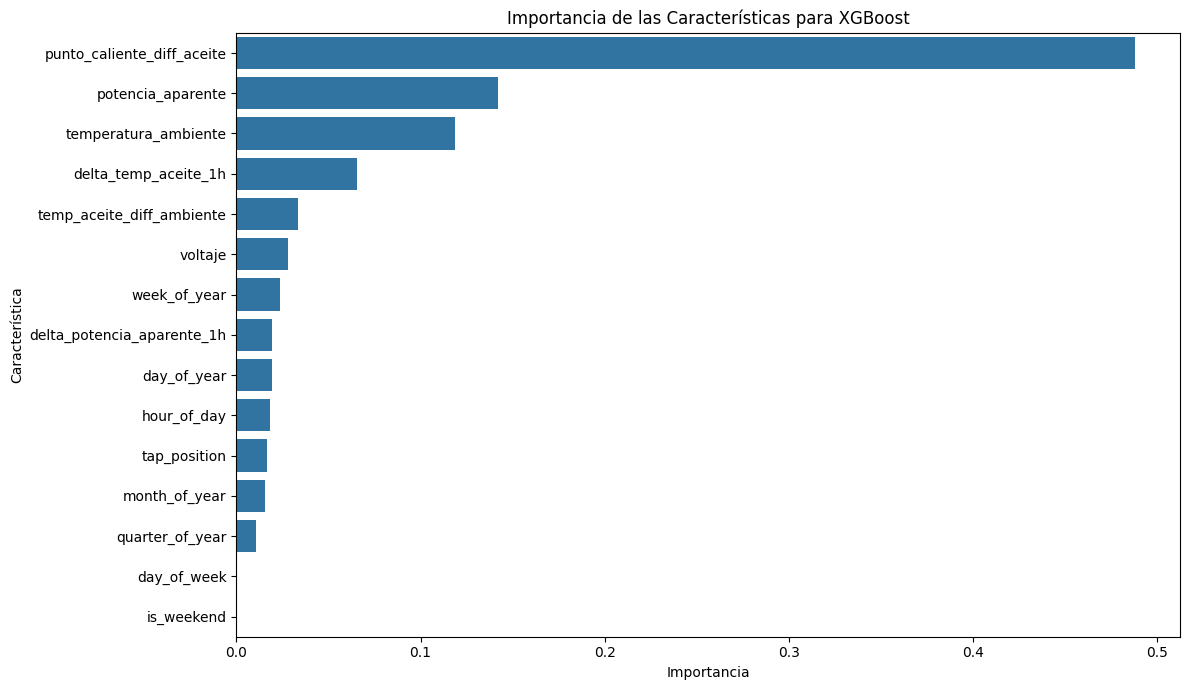

In [19]:
print("\n--- Importancia de las Características ---")

# Usar el modelo que mejor se desempeñó en la evaluación (ej. xgb_model)
# Si te decides por Random Forest, usa rf_model
model_for_importance = xgb_model # O rf_model
model_name_for_importance = "XGBoost" # O "Random Forest"

if hasattr(model_for_importance, 'feature_importances_'):
    feature_importances = model_for_importance.feature_importances_
    features = X_train.columns # Asegúrate de que esta lista de features es la misma que usaste para X_train

    # Crear un DataFrame para visualizar mejor
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print(f"\nTop 10 Características más Importantes para {model_name_for_importance}:")
    print(importance_df.head(10))

    # Visualizar la importancia de las características
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15)) # Muestra las 15 principales
    plt.title(f'Importancia de las Características para {model_name_for_importance}')
    plt.xlabel('Importancia')
    plt.ylabel('Característica')
    plt.tight_layout()
    plt.show()
else:
    print(f"El modelo {model_name_for_importance} no tiene el atributo 'feature_importances_'.")

In [20]:
# from sklearn.model_selection import GridSearchCV

# print("\n--- Afinación de Hiperparámetros con GridSearchCV (Ejemplo con Random Forest) ---")

# # Define el espacio de búsqueda de hiperparámetros
# # ¡IMPORTANTE! Empieza con un rango pequeño para no tardar mucho
# # Y adapta estos parámetros a tu modelo elegido (RF o XGBoost)
# param_grid_rf = {
#     'n_estimators': [50, 100, 200], # Número de árboles
#     'max_depth': [None, 10, 20],   # Profundidad máxima de cada árbol
#     'min_samples_split': [2, 5]    # Mínimo de muestras para dividir un nodo
# }

# # Crea el objeto GridSearchCV
# # cv=3 significa validación cruzada con 3 folds en el conjunto de entrenamiento
# grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
#                               param_grid=param_grid_rf,
#                               scoring='neg_mean_absolute_error', # Para optimizar MAE (negativo porque GridSearchCV maximiza)
#                               cv=3, verbose=1, n_jobs=-1)

# # Ejecuta la búsqueda en el conjunto de entrenamiento (X_train, Y_train)
# # OJO: Esto puede tomar tiempo dependiendo del tamaño de tus datos y del param_grid
# # Si tienes problemas de rendimiento, usa RandomizedSearchCV o un rango más pequeño
# print("Iniciando GridSearchCV para Random Forest...")
# grid_search_rf.fit(X_train, Y_train)
# print("GridSearchCV completado.")

# # Muestra los mejores parámetros encontrados
# print(f"\nMejores parámetros para Random Forest: {grid_search_rf.best_params_}")
# print(f"Mejor MAE (negativo): {-grid_search_rf.best_score_:.3f}")

# # Puedes obtener el mejor modelo entrenado
# best_rf_model = grid_search_rf.best_estimator_

# # Evalúa el mejor modelo en el conjunto de validación
# print("\nEvaluando el mejor modelo Random Forest encontrado por GridSearchCV en VALIDACIÓN:")
# evaluate_model(best_rf_model, X_val, Y_val, "Mejor Random Forest (Validación)")